In [63]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import mar
import preprocessing

In [75]:
pat_num = 14

In [76]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
output_dir = os.path.join(os.path.dirname(os.getcwd()), "output")

if not os.path.exists(os.path.join(data_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(data_dir, f'Patient{pat_num}'))

if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(output_dir, f'Patient{pat_num}'))

In [ ]:
# mar_data = preprocessing.load_mar_data(data_dir, pat_num)
# sickbay_data = preprocessing.load_sickbay_data(data_dir, pat_num)
# sbs_data = preprocessing.load_retro_data(data_dir, pat_num, ignore_default=True)
accel_data = preprocessing.load_accel_data(data_dir, pat_num)
# ecg_data = preprocessing.load_ecg_data(data_dir, pat_num)

In [67]:
mar_narcotics, mar_paralytics, mar_alpha_agonists, mar_ketamines, mar_propofols, mar_etomidates, mar_benzodiazepines = mar.filter_mar(mar_data)
mar_classes = {'narcotics': mar_narcotics, 'paralytics': mar_paralytics, 'alpha_agonists': mar_alpha_agonists, 'ketamines': mar_ketamines, 'propofols': mar_propofols, 'etomidates': mar_etomidates, 'benzodiazepines': mar_benzodiazepines}

for mar_class in mar_classes:
    print(mar_class + " : " + str(mar_classes[mar_class].shape))

narcotics : (921, 4)
paralytics : (0, 4)
alpha_agonists : (933, 4)
ketamines : (14, 4)
propofols : (10, 4)
etomidates : (0, 4)
benzodiazepines : (178, 4)


In [ ]:
drug_doses = {}
drug_concentrations = {}

for mar_class in mar_classes:
    if mar_classes[mar_class].shape[0] < 1:
        continue

    for drug_name in mar.classes()[mar_class]:
        drug_df = mar.filter_drug(mar_classes[mar_class], drug_name)
        
        if drug_df.shape[0] < 1:
            continue

        print(drug_name + " : " + str(drug_df.shape))

        drug_doses[drug_name] = mar.calculate_doses(drug_df)
        # drug_concentrations[drug_name] = mar.calculate_concentrations_rk4(drug_doses[drug_name], elimination_rate=mar.elimination_rates()[drug_name])

print("")

# for drug_name in drug_doses:
#     print(drug_name + " : " + str(drug_doses[drug_name].shape))

fentanyl : (152, 4)
morphine : (4, 4)
hydromorphone : (765, 4)
dexmedetomidine : (933, 4)
ketamine : (14, 4)
propofol : (10, 4)
midazolam : (24, 4)
diazepam : (154, 4)

fentanyl : (38241, 4)
morphine : (11882, 4)
hydromorphone : (46551, 4)
dexmedetomidine : (60158, 4)
ketamine : (15971, 4)
propofol : (9810, 4)
midazolam : (36610, 4)
diazepam : (57418, 4)


In [79]:
metrics = {
    'heart_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'heart_rate': sickbay_data['heart_rate']
    }),
    'respiratory_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'respiratory_rate': sickbay_data['respiratory_rate']
    }),
    'acceleration': pd.DataFrame({
        'time': accel_data['time'],
        'acceleration': accel_data['a']
    }),}

In [80]:
start = max([df['time'].min() for df in metrics.values()])
stop = min([df['time'].max() for df in metrics.values()])

print(start)
print(stop)

2024-02-10 11:10:01
2024-02-22 13:14:57


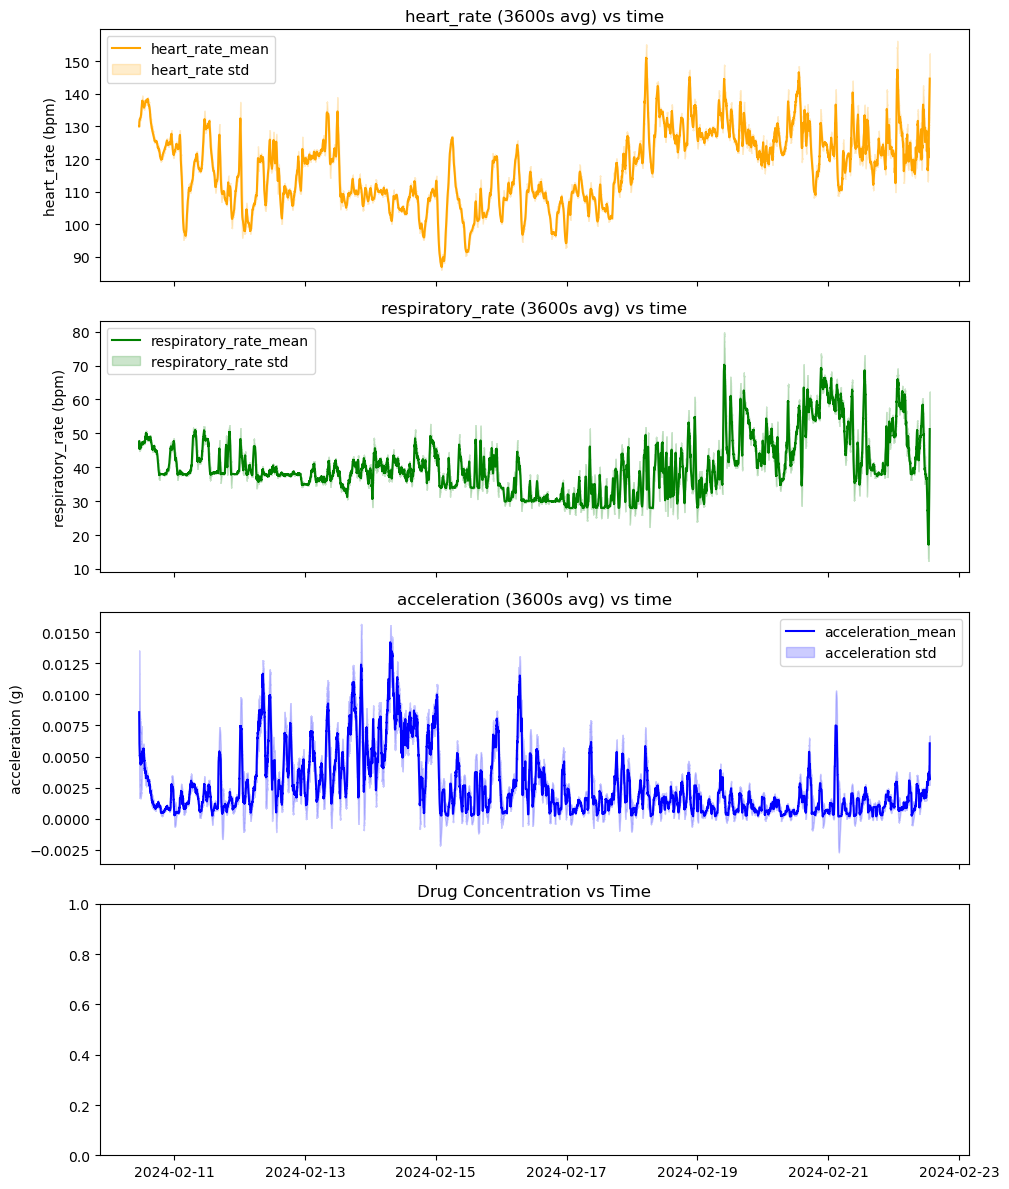

In [81]:
mar.plot_metrics_and_concentrations(metrics, drug_concentrations, drug_name='all', window=3600, std=True, start=start, stop=stop, show=True, save=None)

In [72]:
hydromorphone_doses = drug_doses['hydromorphone']
hydromorphone_doses = hydromorphone_doses[(hydromorphone_doses['time'] >= pd.to_datetime(start)) & (hydromorphone_doses['time'] <= pd.to_datetime(stop))].reset_index(drop=True)
hydromorphone_doses = hydromorphone_doses[hydromorphone_doses['bolus_dose'] != 0].reset_index(drop=True)

print(hydromorphone_doses)

Empty DataFrame
Columns: [time, dose, continuous_dose, bolus_dose]
Index: []


In [73]:
times, doses = [], []

hr_means_before = []
hr_vars_before = []
hr_means_after = []
hr_vars_after = []

rr_means_before = []
rr_vars_before = []
rr_means_after = []
rr_vars_after = []

a_means_before = []
a_vars_before = []
a_means_after = []
a_vars_after = []

for i in range(len(hydromorphone_doses)):
    time = hydromorphone_doses.iloc[i, 0]
    dose = hydromorphone_doses.iloc[i, 3]

    hr = metrics['heart_rate']
    hr_before = hr[(hr['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=30)) & (hr['time'] <= pd.to_datetime(time))].reset_index(drop=True)
    hr_after = hr[(hr['time'] >= pd.to_datetime(time)) & (hr['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=30))].reset_index(drop=True)
    
    rr = metrics['respiratory_rate']
    rr_before = rr[(rr['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=30)) & (rr['time'] <= pd.to_datetime(time))].reset_index(drop=True)
    rr_after = rr[(rr['time'] >= pd.to_datetime(time)) & (rr['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=30))].reset_index(drop=True)

    a = metrics['acceleration']
    a_before = a[(a['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=30)) & (a['time'] <= pd.to_datetime(time))].reset_index(drop=True)
    a_after = a[(a['time'] >= pd.to_datetime(time)) & (a['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=30))].reset_index(drop=True)

    times.append(time)
    doses.append(dose)

    hr_means_before.append(np.mean(hr_before['heart_rate']))
    hr_vars_before.append(np.var(hr_before['heart_rate']))
    hr_means_after.append(np.mean(hr_after['heart_rate']))
    hr_vars_after.append(np.var(hr_after['heart_rate']))

    rr_means_before.append(np.mean(rr_before['respiratory_rate']))
    rr_vars_before.append(np.var(rr_before['respiratory_rate']))
    rr_means_after.append(np.mean(rr_after['respiratory_rate']))
    rr_vars_after.append(np.var(rr_after['respiratory_rate']))

    a_means_before.append(np.mean(a_before['acceleration']))
    a_vars_before.append(np.var(a_before['acceleration']))
    a_means_after.append(np.mean(a_after['acceleration']))
    a_vars_after.append(np.var(a_after['acceleration']))

df = pd.DataFrame({
    'time': times,
    'dose': doses,
    'hr_mean_before': hr_means_before,
    'hr_var_before': hr_vars_before,
    'hr_mean_after': hr_means_after,
    'hr_var_after': hr_vars_after,
    'rr_mean_before': rr_means_before,
    'rr_var_before': rr_vars_before,
    'rr_mean_after': rr_means_after,
    'rr_var_after': rr_vars_after,
    'a_mean_before': a_means_before,
    'a_var_before': a_vars_before,
    'a_mean_after': a_means_after,
    'a_var_after': a_vars_after,})

display(df)

,time,dose,hr_mean_before,hr_var_before,hr_mean_after,hr_var_after,rr_mean_before,rr_var_before,rr_mean_after,rr_var_after,a_mean_before,a_var_before,a_mean_after,a_var_after


In [74]:
delta = np.mean(df['hr_mean_after'] - df['hr_mean_before'])
t_statistic, p_value = stats.ttest_rel(df['hr_mean_before'], df['hr_mean_after'], alternative='greater')

print(f"Change in heart rate mean: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['hr_var_after'] - df['hr_var_before'])
t_statistic, p_value = stats.ttest_rel(df['hr_var_before'], df['hr_var_after'], alternative='greater')

print(f"Change in heart rate variance: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['rr_mean_after'] - df['rr_mean_before'])
t_statistic, p_value = stats.ttest_rel(df['rr_mean_before'], df['rr_mean_after'], alternative='greater')

print(f"Change in respiratory rate mean: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['rr_var_after'] - df['rr_var_before'])
t_statistic, p_value = stats.ttest_rel(df['rr_var_before'], df['rr_var_after'], alternative='greater')

print(f"Change in respiratory rate variance: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['a_mean_after'] - df['a_mean_before'])
t_statistic, p_value = stats.ttest_rel(df['a_mean_before'], df['a_mean_after'], alternative='greater')

print(f"Change in accelerometry mean: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['a_var_after'] - df['a_var_before'])
t_statistic, p_value = stats.ttest_rel(df['a_var_before'], df['a_var_after'], alternative='greater')

print(f"Change in accelerometry variance: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

Change in heart rate mean: nan
T-statistic: nan
P-value: nan

Change in heart rate variance: nan
T-statistic: nan
P-value: nan

Change in respiratory rate mean: nan
T-statistic: nan
P-value: nan

Change in respiratory rate variance: nan
T-statistic: nan
P-value: nan

Change in accelerometry mean: nan
T-statistic: nan
P-value: nan

Change in accelerometry variance: nan
T-statistic: nan
P-value: nan

